# Quantifying uncertainty in model performance 
K-fold cross-validation vs hierarchical bootstrap

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

1. Naïve approach: Just treat fold accuracies as independent samples and compute CI from their standard error.

2. Hierarchical bootstrap: Resample folds and resample points inside folds → capture both levels of uncertainty.

In [8]:
X, y = load_breast_cancer(return_X_y=True)
kf = KFold(n_splits=5, shuffle=True, random_state=0)

# Run k-fold CV
fold_predictions = []
fold_accs = []
for train_idx, test_idx in kf.split(X):
    model = LogisticRegression(max_iter=5000)
    model.fit(X[train_idx], y[train_idx])
    y_pred = model.predict(X[test_idx])
    fold_predictions.append((y[test_idx], y_pred))
    fold_accs.append(accuracy_score(y[test_idx], y_pred))

mean_acc = np.mean(fold_accs)
se_naive = np.std(fold_accs, ddof=1) / np.sqrt(len(fold_accs))
ci_naive = (mean_acc - 1.96*se_naive, mean_acc + 1.96*se_naive)

print("Naive approach:")
print(f"  Mean = {mean_acc:.4f}")
print(f"  SE   = {se_naive:.4f}")
print(f"  95% CI = [{ci_naive[0]:.4f}, {ci_naive[1]:.4f}]")


Naive approach:
  Mean = 0.9526
  SE   = 0.0148
  95% CI = [0.9235, 0.9816]


In [9]:
def hierarchical_bootstrap(fold_predictions, B=2000):
    boot_means = []
    for _ in range(B):
        chosen_folds = np.random.choice(len(fold_predictions), len(fold_predictions), replace=True)
        fold_accs = []
        for f in chosen_folds:
            y_true, y_pred = fold_predictions[f]
            idx = np.random.choice(len(y_true), len(y_true), replace=True)
            acc = accuracy_score(y_true[idx], y_pred[idx])
            fold_accs.append(acc)
        boot_means.append(np.mean(fold_accs))
    return np.array(boot_means)

boot_means = hierarchical_bootstrap(fold_predictions, B=5000)
boot_mean = np.mean(boot_means)
se_boot = np.std(boot_means, ddof=1)
ci_boot = (np.percentile(boot_means, 2.5), np.percentile(boot_means, 97.5))

print("\nHierarchical bootstrap:")
print(f"  Mean = {boot_mean:.4f}")
print(f"  SE   = {se_boot:.4f}")
print(f"  95% CI = [{ci_boot[0]:.4f}, {ci_boot[1]:.4f}]")


Hierarchical bootstrap:
  Mean = 0.9526
  SE   = 0.0161
  95% CI = [0.9192, 0.9807]


# Visualization

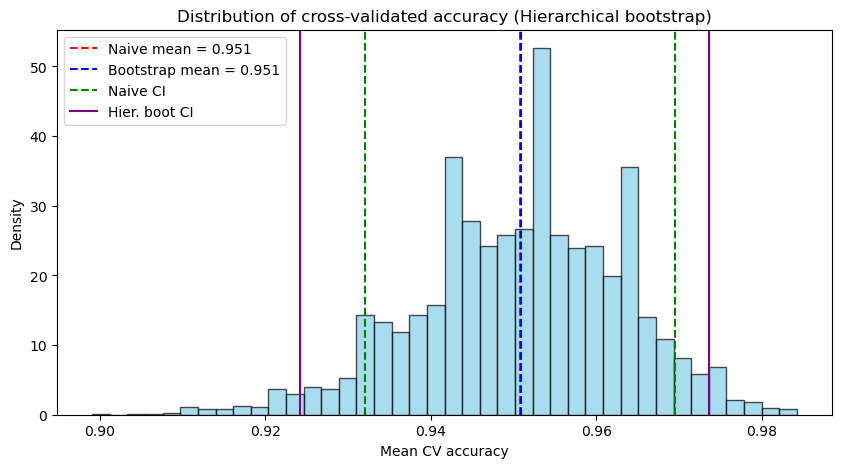

In [6]:
plt.figure(figsize=(10,5))

plt.hist(boot_means, bins=40, alpha=0.7, color='skyblue', edgecolor='black', density=True)

# mean estimates
plt.axvline(mean_acc, color='red', linestyle='--', label=f"Naive mean = {mean_acc:.3f}")
plt.axvline(np.mean(boot_means), color='blue', linestyle='--', label=f"Bootstrap mean = {np.mean(boot_means):.3f}")

# naive CI
plt.axvline(ci_naive[0], color='green', linestyle='--', label=f"Naive CI")
plt.axvline(ci_naive[1], color='green', linestyle='--')

# bootstrap CI
plt.axvline(ci_boot[0], color='purple', linestyle='-', label=f"Hier. boot CI")
plt.axvline(ci_boot[1], color='purple', linestyle='-')

plt.title("Distribution of cross-validated accuracy (Hierarchical bootstrap)")
plt.xlabel("Mean CV accuracy")
plt.ylabel("Density")
plt.legend()
plt.show()